In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image

## Animation with numpy

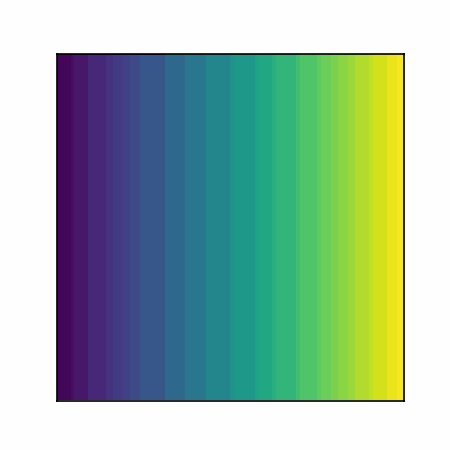

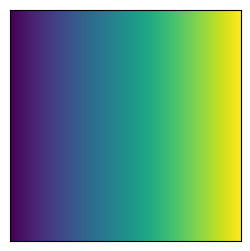

In [2]:
img = np.array(list(range(0, 100)) * 100).reshape((100, 100))
N = 30
img_hist = [np.roll(img, n) for n in range(N)]


### generate gif
fig, ax = plt.subplots(figsize=(3, 3))


def AnimationFunction(frame):
    ax.imshow(img_hist[frame])
    ax.set_xticks([])
    ax.set_yticks([])


anim_created = FuncAnimation(fig, AnimationFunction, frames=N, interval=1)
anim_created.save("HW2task3.gif", dpi=150, writer=PillowWriter(fps=2))
Image("HW2task3.gif")

## animation with MPI

In [3]:
%%writefile task3.py
from mpi4py import MPI
import numpy as np
import time as  timer
import sys
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
amode = MPI.MODE_WRONLY|MPI.MODE_CREATE

N = int(sys.argv[1])

rows = 5
cols = 10
img = np.array(list(range(0,cols)) * rows).reshape((rows,cols)).astype(np.uint8)
# img = (np.random.random((rows,cols)) * 100).astype(np.uint8)


col_step = cols //size
if rank == size -1:
    col_w = col_step + cols %size
else:
    col_w = col_step

img_share = img[:,col_step * rank : col_step * rank + col_w]

for i in range(1,N):

    id_next = (rank + 1) % size
    id_prev = (rank - 1) % size

    buffer = np.empty(rows,dtype=np.uint8)
    buffer[:] = img_share[:,-1]
    comm.Send([buffer, MPI.UNSIGNED_CHAR],dest =  id_next,tag=0)
    img_share = np.roll(img_share,1)
    comm.Recv([buffer, MPI.UNSIGNED_CHAR],source = id_prev,tag=0)
    img_share[:,0]=buffer
    
    fh = MPI.File.Open(comm, f"./task3_itter{i}.txt", amode)
    offset =  comm.Get_rank() * rows*col_step
    fh.Write_at_all(offset,img_share.T.flatten())
    fh.Close()

MPI.Finalize()

Overwriting task3.py


In [4]:
N = 20
!mpirun -n 7 python task3.py {N}

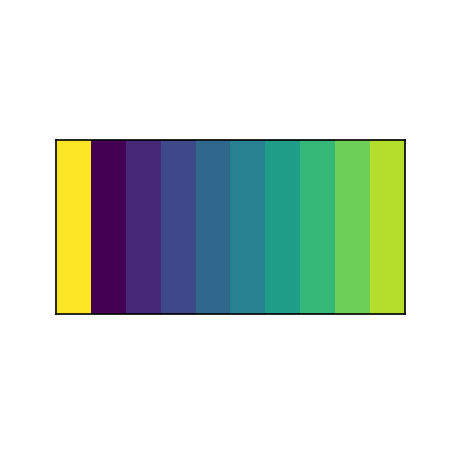

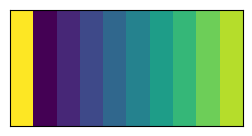

In [5]:
img_list = []
for i in range(1, N):
    img = np.fromfile(f"task3_itter{i}.txt", dtype=np.uint8).reshape(10, 5).T
    img_list.append(img)


### generate gif
fig, ax = plt.subplots(figsize=(3, 3))


def AnimationFunction(frame):
    ax.imshow(img_list[frame])
    ax.set_xticks([])
    ax.set_yticks([])


anim_created = FuncAnimation(fig, AnimationFunction, frames=N - 1, interval=1)
anim_created.save("HW2task32.gif", dpi=150, writer=PillowWriter(fps=5))
Image("HW2task32.gif")